In [1]:
# cd /sc/orga/projects/clemej05a/FACS/FMT/inputs/run.20180314/FCM/FCM_data
# you can use only FCS-A, SSC-A,  FCS-W, SSC-W Blue1 and Blue4 columns
import pandas as pd
from glob import glob
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
files = glob('/Users/KevinBu/Desktop/clemente_lab/iclust/data/FCM_data/*.csv')
# need to determine if image can separate clusters into either (1) patients 
# (2) remission or not; 

In [4]:
%%capture
# for each pair of variables (combinations)
# create directory within plots
# create plots

variables = ['FSC-A', 'FSC-W', 'SSC-A', 'SSC-W', 'Blue1-A', 'Blue4-A']
var_pairs = [x for x in itertools.combinations(variables,2)]
for var_pair in var_pairs:
    var1, var2 = var_pair
    dir_name = '/Users/KevinBu/Desktop/clemente_lab/iclust/data_analysis/FCM_data/' + var1 + '_' + var2 
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

        
for var_pair in var_pairs:
    var1, var2 = var_pair
    dir_name = '/Users/KevinBu/Desktop/clemente_lab/iclust/data/FCM_data/' + var1 + '_' + var2 + '/plots/'
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    for f in files:
        sample = os.path.basename(f).split('.csv.csv')[0]
        df = pd.read_csv(f).loc[:,var_pair]
        df = df.apply(np.abs)
        df = df.apply(np.log10)
        fig = plt.figure()
        sns_plot = sns.lmplot(var1, var2, data = df, 
                              fit_reg = False, palette = "Set1", scatter_kws={'alpha':0.3})

        ax = plt.gca()
        axes = sns_plot.axes
        ax.set_position(np.array([.1,.1,.8,.8]))
        plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, 
                        labelbottom=False, labelleft=False)
        ax.set_ylabel('')    
        ax.set_xlabel('')
        ax.set_title('')
        # plt.figure(figsize=(3,3))
        plt.ticklabel_format(useOffset=False, style='plain', axis='both')
        fig.patch.set_visible(False)
        ax.patch.set_visible(False)
        plt.savefig(dir_name + '/' + sample + '.jpeg')
        plt.close()
        
        


In [5]:
from PIL import Image
from collections import defaultdict
from decimal import Decimal
from scipy.cluster import hierarchy
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette, linkage
from matplotlib.colors import rgb2hex, colorConverter
from sklearn.metrics import v_measure_score, silhouette_score
%matplotlib inline
sns.set_style("white")


In [8]:
# functions for image processing and output
def avg_image(imlist, string):
    w,h=Image.open(imlist[0]).size
    N=len(imlist)

    # Create a numpy array of floats to store the average (assume RGB images)
    arr=np.zeros((h,w,3),np.float)

    # Build up average pixel intensities, casting each image as an array of floats
    for im in imlist:
        imarr=np.array(Image.open(im),dtype=np.float)
        arr=arr+imarr/N

    # Round values in array and cast as 8-bit integer
    arr=np.array(np.round(arr),dtype=np.uint8)

    # Generate, save and preview final image
    out=Image.fromarray(arr,mode="RGB")
    out.save(path + string + '.jpg')

def corr_order(path, R, string):
    #try:
    image_list = [path + 'plots/' + x for x in R['ivl']]
    #except:
    #   new_R = [str(x[0]) for x in R['ivl']]
    #   image_list = [path + 'plots/' + x for x in new_R]
        
    images = list(map(Image.open, image_list))
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im.save(path + string + '.jpg')
    
def score_clusters(max_clust, Z, groups, ids, noncond_dist):
    # groups is the truth, labels is the predicted
    # Z is linkage matrix 
    # ids is the names of the files corresponding to the order in which Z was created
    ss = []
    vms = []
    n_clust = []
    
    for k in range(2, max_clust+1):
        cut = hierarchy.fcluster(Z, k, criterion='maxclust')
        cluster_dct = dict((ii,[]) for ii in np.unique(cut))
        for iimg,iclus in enumerate(cut):
            cluster_dct[iclus].append(ids[iimg])

        clusters = list(cluster_dct.values())
        observed = dict()
        for i in range(len(clusters)):
            for item in clusters[i]:
                observed[item] = i

        obs_labels = []
        for item in ids:
            obs_labels.append(observed[item])

        if len(np.unique(obs_labels)) > 1:
            ss.append(silhouette_score(noncond_dist, obs_labels, metric='euclidean'))
            vms.append(v_measure_score(groups, obs_labels))
            n_clust.append(len(clusters))
        else:
            ss.append(-1)
            vms.append(-1)
            n_clust.append(1)
    
    corr_score_df = pd.DataFrame({'ss': ss, 'vms': vms, 'n_clust': n_clust})

    best_ss_df = corr_score_df.loc[corr_score_df['ss'] == max(corr_score_df['ss'])]
    best_vms_df = corr_score_df.loc[corr_score_df['vms'] == max(corr_score_df['vms'])]        
    return ss, vms, best_ss_df, best_vms_df, n_clust, corr_score_df

def print_avg_order(Z, k, ids, path, string, R):
    cut = hierarchy.fcluster(Z, 2, criterion='maxclust')
    cluster_dct = dict((ii,[]) for ii in np.unique(cut))
    for iimg,iclus in enumerate(cut):
        cluster_dct[iclus].append(ids[iimg])

    clusters = list(cluster_dct.values())
    '''try:
        image_list = [path + 'plots/' + x for x in R['ivl']]
    except:
        new_R = [str(x[0]) for x in R['ivl']]
        image_list = [path + 'plots/' + x for x in new_R]'''
    i = 0
    for cluster in clusters:
        image_list = [path + 'plots/' + x for x in cluster]
        i += 1
        avg_image(image_list, 'avg_img_' + str(k) + '_' + str(i))

    corr_order(path, R, string)
    
print('Done')

Done


best ss n_clust: 2 with score 0.24613604329778258
[0.24613604329778258, 0.1796714986839459, 0.15569465741523092, 0.11567789857427868, 0.09521432583143333, 0.09176549468429812, 0.1008497595130781, 0.08257494257850229, 0.07083247626617686, 0.057823866287453486, 0.08026429281973156, 0.06929258226399512, 0.05512549166761187, 0.050717470856858154, 0.04389956323301193, 0.04551230989005016, 0.11832276884385998, 0.1000543947601267, 0.1000543947601267]
best vms n_clust: 19 with score 0.746698672415822
[0.11735168327026188, 0.18656242957079283, 0.26314460777892107, 0.3103329467774856, 0.3490898364935511, 0.4571094504459613, 0.5029983335306405, 0.53119747343495, 0.583378570322225, 0.6677644509979612, 0.7039557359672066, 0.7237685957022465, 0.7128708124944356, 0.7095215556985465, 0.7282807621943455, 0.7217696391568916, 0.7294347506248864, 0.746698672415822, 0.746698672415822]
best ss n_clust: 2 with score 0.3179068612608059
[0.3179068612608059, 0.13243915707866294, 0.09910202076175724, 0.112636265

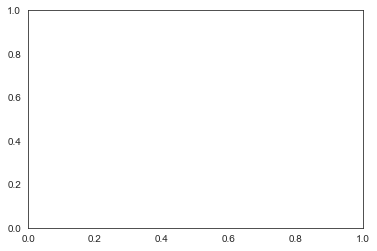

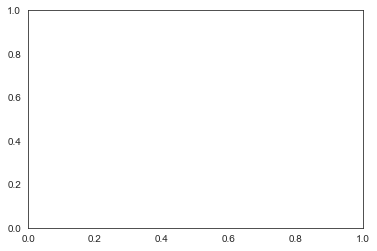

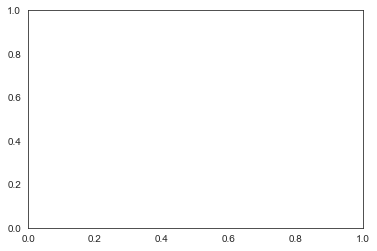

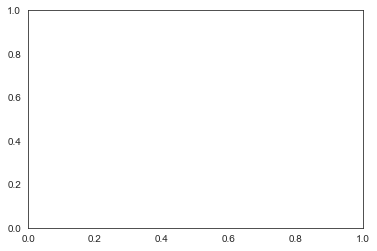

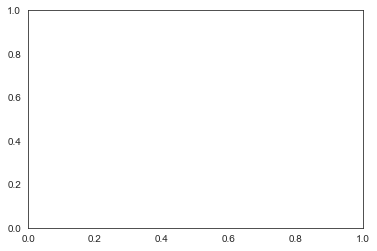

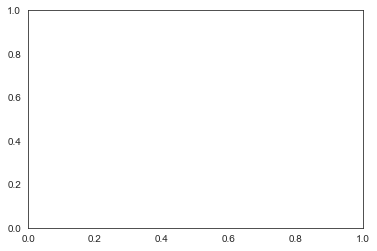

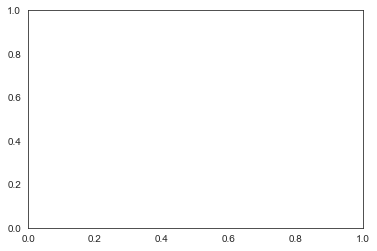

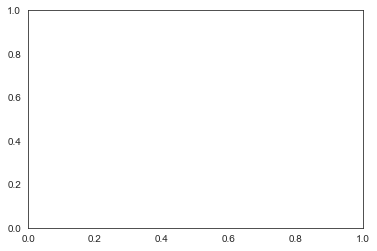

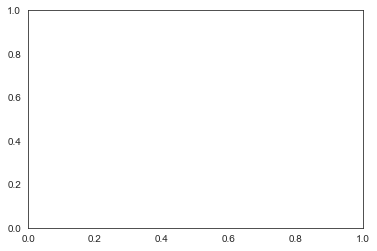

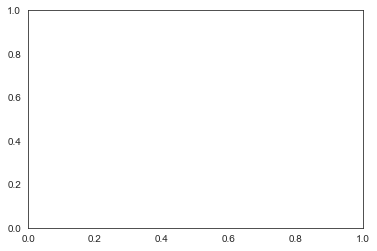

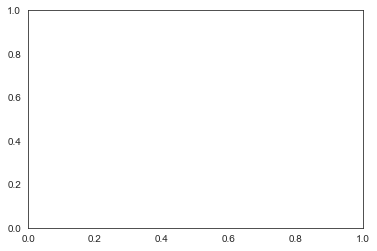

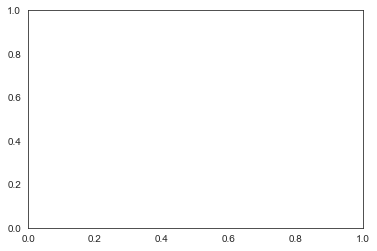

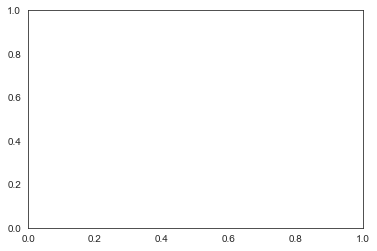

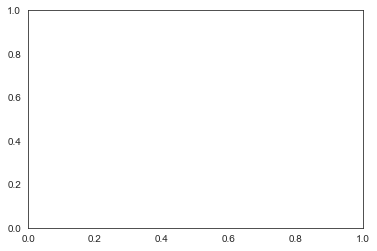

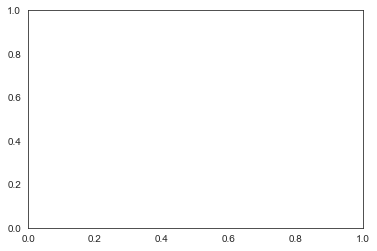

In [9]:
paths = glob('/Users/KevinBu/Desktop/clemente_lab/iclust/data_analysis/FCM_data/*')
for path in paths:
    path = path + '/'
    dfps_df = pd.read_csv(path + 'dfps.txt', sep = '\t', header = None).drop(0) # first row is junk
    cond = dfps_df.iloc[:,1:].values.flatten()
    sq = distance.squareform(cond)
    noncond_dist = distance.squareform(cond)

    # get assigned labels
    cluster_df = pd.read_csv(path + 'cluster_array.txt', sep = '\t', header = None)
    # cluster_df['group'] = [x.split('/')[2].split('_')[0] for x in cluster_df.iloc[:,0].values]
    # assigned_labels = cluster_df['group']

    # get linkage matrix
    df = pd.read_csv(path + 'Z.txt', sep = '\t')
    Z = df.values[:,1:]

    # get name ordering as processed by software
    names = pd.read_csv(path + 'names.txt', sep = '\t')


    names = [os.path.basename(str(x[0])) for x in list(names.values[:,1:])]
    # grouping by name i.e. by sample
    true_labels = [x.split('.')[0][1] for x in names]
    # could also group by other e.g. PRE POST or DONORA

    fig, ax = plt.subplots()
    plt.figure(figsize=(20,10)) 
    plt.title('Hierarchical Clustering Dendrogram (imageclust)')
    plt.xlabel('plot name')
    plt.ylabel('distance (imageclust)') # or corr
    R = dendrogram(Z, labels = names, leaf_rotation = 90)
    plt.savefig(path + 'dendrogram.pdf')
    plt.close()
    # R['ivl'] = [list(x) for x in R['ivl']]
    max_clust = 20

    ss, vms, best_ss_df, best_vms_df, n_clust, corr_score_df = score_clusters(max_clust, Z, true_labels, names, noncond_dist)
    # print 'sigma = ' + str(sigma)
    print('best ss n_clust: ' + str(best_ss_df['n_clust'].values[0]) + ' with score ' +  str(best_ss_df['ss'].values[0]))
    print(ss)
    print('best vms n_clust: ' + str(best_vms_df['n_clust'].values[0]) + ' with score ' +  str(best_vms_df['vms'].values[0]))
    print(vms)
    k = best_vms_df['n_clust'].values[0] # toggle here
    print_avg_order(Z, k, names, path, 'imgclust_order', R)

['6', '6', '3', '5', '3', '5', '7', '6', '1', '2', '2', '4', '1', '3', '4', '7', '7', '2', '5', '4', '1']


In [23]:
dfps = {
    'A_1_0.091.jpg': np.array([1,2,3,4]),
    'A_2_0.190.jpg': np.array([1.1,2.1,3.1,4.1]),
    'B_1_0.190.jpg': np.array([4,5,6,7]),
    'B_2_0.190.jpg': np.array([4.1,5.1,6.1,7.1])
}

In [24]:
from sklearn.decomposition import PCA
# construct a df from the fingerprints and have a group label corresponding to original class
indices = []
values = []
for img, fp in dfps.items():
    indices.append(img)
    values.append(fp)
    
values = np.stack(values, axis=0)
print(indices)
print(values)

df = pd.DataFrame(data=values, index=indices)
df['group'] = [str(x).split('_')[0] for x in df.index.values]
df.head()


['A_1_0.091.jpg', 'A_2_0.190.jpg', 'B_1_0.190.jpg', 'B_2_0.190.jpg']
[[1.  2.  3.  4. ]
 [1.1 2.1 3.1 4.1]
 [4.  5.  6.  7. ]
 [4.1 5.1 6.1 7.1]]


,0,1,2,3,group
A_1_0.091.jpg,1.0,2.0,3.0,4.0,A
A_2_0.190.jpg,1.1,2.1,3.1,4.1,A
B_1_0.190.jpg,4.0,5.0,6.0,7.0,B
B_2_0.190.jpg,4.1,5.1,6.1,7.1,B


[1.20133333e+01 4.60449991e-32 7.36333094e-33]


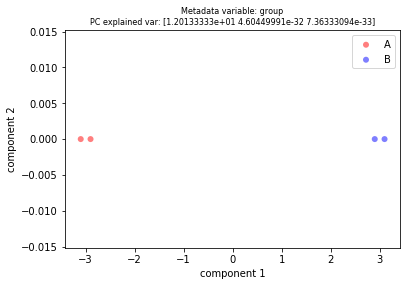

In [34]:
variable = 'group'
X = df.drop(variable,axis=1)
y = df[variable]
pca = PCA(n_components=3)
pca.fit(X)
ev = pca.explained_variance_
#print pca.components_
print(pca.explained_variance_)
pca = PCA(2) 
projected = pca.fit_transform(X)
colors = ['red', 'blue']
points = {}
unique_vals = df[variable].unique()

for v in range(len(unique_vals)):
    points[v] = plt.scatter(projected[:, 0][df[variable] == unique_vals[v]],
                            projected[:, 1][df[variable] == unique_vals[v]], 
                            #projected[:, 2],
                            c=colors[v],
                            edgecolor='none', alpha=0.5)  #cmap=plt.cm.get_cmap('Spectral', 10))\n",
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title('Metadata variable: ' + variable + '\n' +
              'PC explained var: ' + str(ev),  fontsize=8)
    plt.legend([points[v] for v in points], unique_vals)
    #plt.savefig('PCA_' + variable + '_' + sub + '.pdf')
    #plt.close('all')

In [29]:
unique_vals

array(['A', 'B'], dtype=object)

In [32]:
[points[v] for v in points]

In [1]:
import numpy as np
from scipy.linalg import toeplitz
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
dep_top = toeplitz(np.arange(1.0, -1.0, -2.0/(500)))

In [6]:
values = dep_top.flatten()

In [11]:
fig = plt.figure()
sns.distplot(values, bins=20, kde=False, rug=False)
plt.ylim(0, int(500*500/10))
plt.xlim(-1, 1)
ax = plt.gca()
ax.set_title(label='Correlation Coefficients', fontsize=10)
fig.patch.set_visible(False)
ax.patch.set_visible(False)
fig.set_tight_layout(True)
plt.tick_params(axis='both', which='both', top=False, right=False, bottom=False, left=False)
sns.despine()
plt.savefig('test.pdf')
plt.close('all')

In [14]:
len(dep_top[np.triu_indices(500, k = 1)])

124750